Predict vendor from artificially-generated sequence using Bayes' method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

import datetime
from dateutil.parser import parse

import math
import os
import copy
import pickle

In [2]:
# Import data
import pickle
file = open('art_data.pkl','rb')
data = pickle.load(file)
file.close()

file = open('art_train.pkl','rb')
train = pickle.load(file)
file.close()

file = open('art_test.pkl','rb')
test = pickle.load(file)
file.close()

## "Train" Bayes' model

In [5]:
# Get probability for a variable given another variable
def get_cond_probDist(category, var = 'vendor_name', given_var = 'drug'):
#     Function gets probability distribution of 'var' given 'given_var' is 'category'
#     Args: 'category' is the class of given_var
#           'var' is the random variable for which the prob. dist. is computed
#           'given_var' is the random variable which is given
#     Returns: series, representing proportion of total for each drug
    subset = train[train[given_var] == category]
    tally = subset[given_var].groupby(subset[var]).count()
    return(tally/np.sum(tally))

# Create dictionary to predict using Bayes' Rule (i.e. using conditional probability)
def trainBayes(var = 'vendor_name', given_var = 'drug'):
#     Function returns a dictionary with sorted probabilities for 'var' given 'given_var'
#     Args: 'var' is the name of the variable to predict
#           'given_var' is the name of the given variable
#     Returns: dictionary with keys for each possible outcome of 'given_var', and values corresponding to 
#                 sorted probabilities for each outcome of 'var'
    
    # Get list of unique vendors and of unique drugs
    cols = train[var].unique()
    rows = train[given_var].unique()

    #Create conditional probability dataframe
    cond_prob_df = pd.DataFrame(columns = cols)
    
    #Insert given variable name column
    cond_prob_df.insert(0, given_var, rows)
    
    # Apply function to dataframe
    cond_prob_df.iloc[:,1:] = \
        cond_prob_df[given_var].apply(get_cond_probDist, var = 'vendor_name', given_var = 'drug')
    
    # fill NA values with 0
    cond_prob_df = cond_prob_df.fillna(0)
    
    # Set index to be given variable
    cond_prob_df = cond_prob_df.set_index(given_var)
    
    # Create dictionary with sorted predictions for each outcome of given variable
#     First key is one of drugs
#     Second key is either 'vendor' or 'prob'
#     'vendor' are the most probable vendors, sorted by probability
#     'prob' corresponds to the probability for each vendor
    bayes_dict = {drug : {'vendor':list(cond_prob_df.loc[drug].sort_values(ascending = False).index),\
                          'prob':list(cond_prob_df.loc[drug].sort_values(ascending = False).values)} \
                  for drug in cond_prob_df.index}    

    return(bayes_dict)

## Evaluate model

In [6]:
bayes_model = trainBayes()

# Function to predict class for each drug in test set
def bayesPredict(obs_seq):
    preds = [bayes_model[obs]['vendor'] for obs in obs_seq]
    return(preds)

# Get times for testing
d_test = list(test['drug'])

# Make predictions
test['vendor_pred'] = bayesPredict(d_test)

In [28]:
for drug in bayes_model.keys():
    print(drug)

cocaine
benzodiazepines
ecstasy
dmt
buprenorphine
methamphetamine
others
heroin
ketamine
lsd
marijuana
oxycodone
hashish
psilocybin
amphetamine


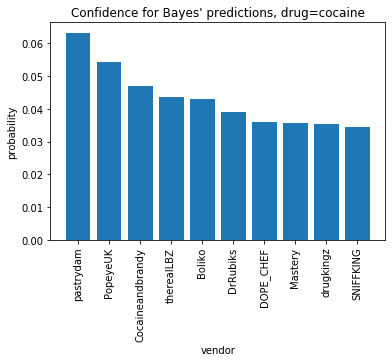

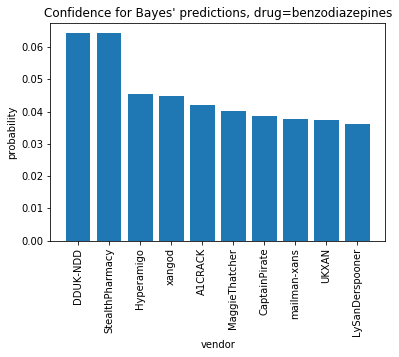

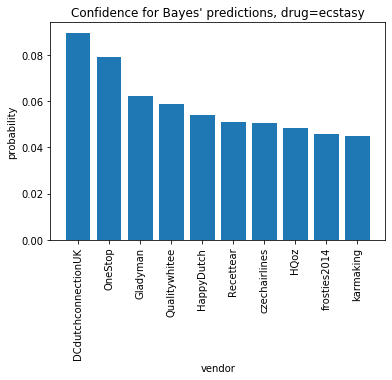

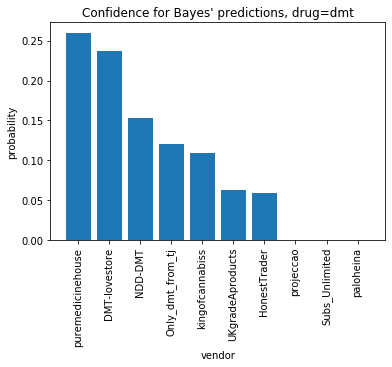

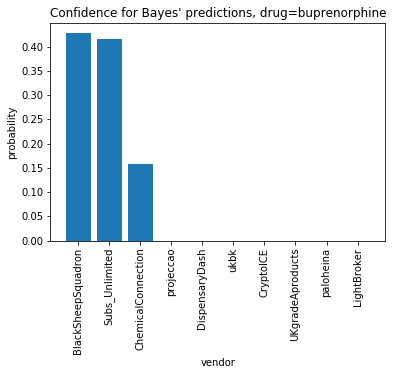

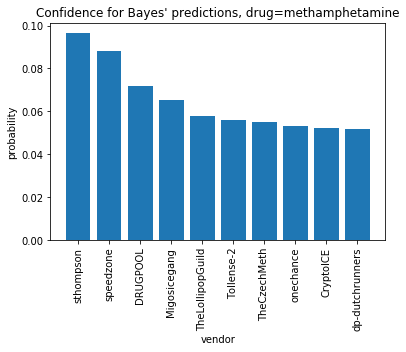

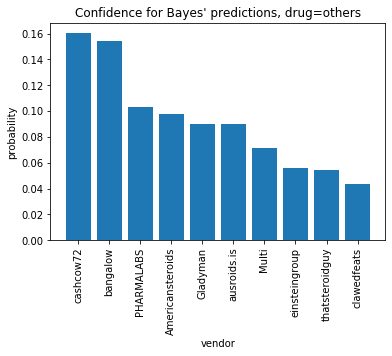

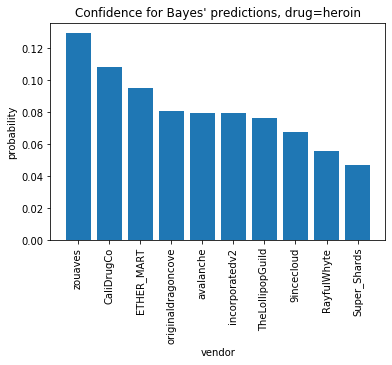

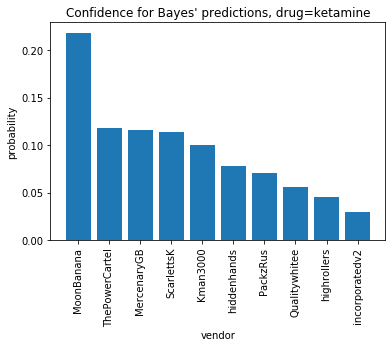

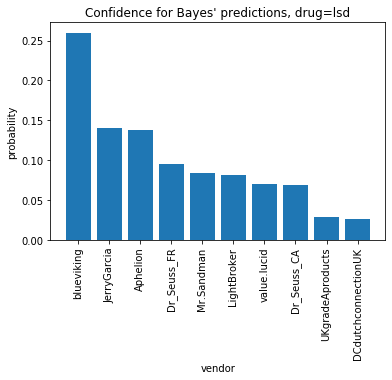

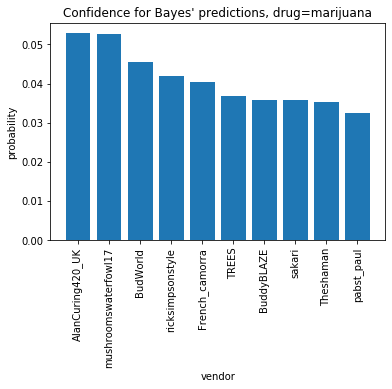

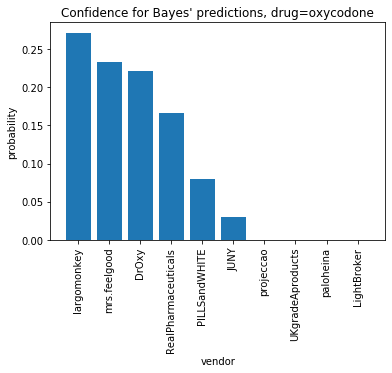

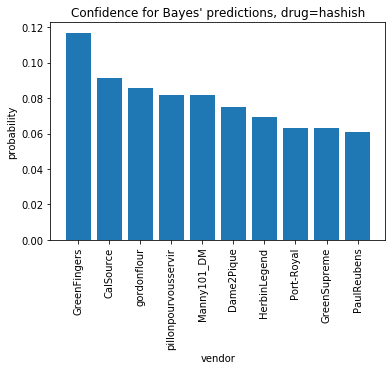

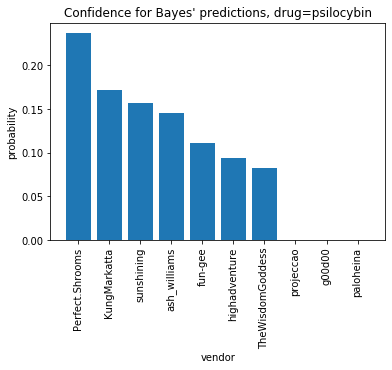

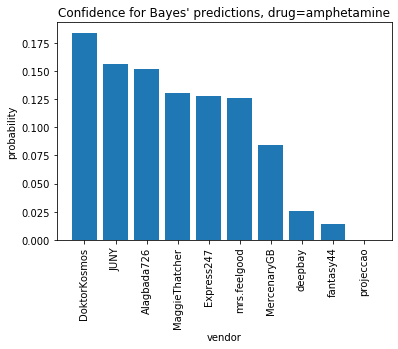

In [34]:
n = 10
for drug in bayes_model.keys():
    plt.bar(bayes_model[drug]['vendor'][:n], bayes_model[drug]['prob'][:n])
    plt.xlabel('vendor')
    plt.ylabel('probability')
    plt.title('Confidence for Bayes\' predictions, drug='+drug)
    plt.xticks(rotation=90)
    plt.show()

In [38]:
# Get mean/median probabilities for top1/5/10
top1_vals = []
top5_vals = []
top10_vals = []

for drug in train['drug'].unique():
    if sum(bayes_model[drug]['prob'][:10])!=0:
        top1_vals.append(bayes_model[drug]['prob'][0])
        top5_vals.append(sum(bayes_model[drug]['prob'][:5]))
        top10_vals.append(sum(bayes_model[drug]['prob'][:10]))
        
print(np.mean(top1_vals))
print(np.median(top1_vals),'\n')

print(np.mean(top5_vals))
print(np.median(top5_vals),'\n')

print(np.mean(top10_vals))
print(np.median(top10_vals),'\n\n\n')

# Get mean/median probabilities for top1/5/10
top1_vals = []
top5_vals = []
top10_vals = []

for drug in train['drug'].unique():
    top1_vals.append(bayes_model[drug]['prob'][0])
    top5_vals.append(sum(bayes_model[drug]['prob'][:5]))
    top10_vals.append(sum(bayes_model[drug]['prob'][:10]))
        
print(np.mean(top1_vals))
print(np.median(top1_vals),'\n')

print(np.mean(top5_vals))
print(np.median(top5_vals),'\n')

print(np.mean(top10_vals))
print(np.median(top10_vals),'\n\n\n')

# Also get percentage of 'zero' keys
zero_count = 0
for drug in train['drug'].unique():
    if bayes_model[drug]['prob'][0]==0:
        zero_count += 1
print(zero_count/len(train['drug'].unique()))

0.17535659137665344
0.16035182679296348 

0.5887234115430481
0.6048714479025711 

0.799534988266043
0.9215155615696888 



0.17535659137665344
0.16035182679296348 

0.5887234115430481
0.6048714479025711 

0.799534988266043
0.9215155615696888 



0.0


In [39]:
# Compute 'top n' accuracy
def get_top_n(n,df=test):
    q = zip(df['vendor_name'], df['vendor_pred'])
    if n == 1:
        ar = [samp[0] == samp[1][0] for samp in q]
    else:
        ar = [samp[0] in samp[1][:n] for samp in q]
    acc = np.sum(ar)/len(ar)
    return(round(acc,4))

In [40]:
n_vals = [1,5,10]
for n in n_vals:
    print('Top',n,'accuracy:',get_top_n(n))

Top 1 accuracy: 0.1251
Top 5 accuracy: 0.4331
Top 10 accuracy: 0.6597
